# Gold Futures Price and Volatility Curves

## Summary
A quick analysis on gold future prices downloaded from TurtleTrader.com.  Given that every future contract is priced and traded based on days to maturity at the point in time, there are two ways to convert them into continual time series: **Nearbys** or **Constant Maturity** price series.

Below demostrated the generation and creation of these time series.  More details can be found [here](https://www.value-at-risk.net/futures-prices/).

## Data
Data gathered from TurtleTrader.com [here](https://www.turtletrader.com/hpd/).


## Import Libraries

In [1]:
import time
import re
import random
import numpy as np
import pandas as pd

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

## Changing the default settings
pd.options.display.max_columns = 50
plt.rcParams.update({'figure.figsize':(15,6), 'figure.dpi':60})
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

## Loading Raw Prices

In [2]:
import os
from datetime import date
from dateutil.relativedelta import relativedelta
from tqdm.notebook import tqdm

PRICE_FOLDER = '../data/gold/'
filelist = []

for dirname, _, filenames in os.walk(PRICE_FOLDER):
    for filename in filenames:
        filelist.append(os.path.join(dirname, filename))

In [3]:
prices_full = []
filelist2 = []
filelist3 = []

print('Number of files to process: {}'.format(len(filelist)))

for file in tqdm(filelist):
    try:
        prices = pd.read_csv(file, header=None, dtype={0:'str'})
        prices.columns = ['date', 'open', 'high', 'low', 'close', 'volume', 'open_interest']
        prices.date = pd.to_datetime(prices.date, format='%y%m%d')
        maturity_date = max(prices.date) + relativedelta(days=1)
        prices['maturity_date'] = maturity_date
        prices['days_to_maturity'] = prices.maturity_date - prices.date
        prices['days_to_maturity'] = prices.days_to_maturity.dt.days
        prices_full.append(prices)
    except:        
        filelist2.append(file)

for file in tqdm(filelist2):
    try:
        prices = pd.read_csv(file, dtype={0:'str'})
        prices.columns = ['date', 'open', 'high', 'low', 'close', 'volume', 'open_interest']
        prices.date = pd.to_datetime(prices.date, format='%m/%d/%Y')
        maturity_date = max(prices.date) + relativedelta(days=1)
        prices['maturity_date'] = maturity_date
        prices['days_to_maturity'] = prices.maturity_date - prices.date
        prices['days_to_maturity'] = prices.days_to_maturity.dt.days
        prices_full.append(prices)
    except:        
        filelist3.append(file)
        
print('Number of files processed successfully: {}'.format(len(prices_full)))
prices_full = pd.concat(prices_full)    

Number of files to process: 214



Number of files processed successfully: 214


## Nearby Futures Prices

In [4]:
prices_full.sort_values(['date','maturity_date'], inplace=True)

In [5]:
def generate_nearby(prices_full, N):

    prices_nearby = []

    for dt in prices_full.date.unique():
        px = prices_full[(prices_full.date == dt) & (prices_full.days_to_maturity >= 14)]
        if px.shape[0] > N:
            prices_nearby.append(px.iloc[[N-1]])

    prices_nearby = pd.concat(prices_nearby)
    prices_nearby.set_index('date', inplace=True)        
    
    return prices_nearby[['close']]

In [6]:
prices_nearby_first = generate_nearby(prices_full, 1)
prices_nearby_second = generate_nearby(prices_full, 2)
prices_nearby_third = generate_nearby(prices_full, 3)

In [7]:
prices_nearby = prices_nearby_first.merge(prices_nearby_second, left_index=True, 
                                          right_index=True)
prices_nearby = prices_nearby.merge(prices_nearby_third, left_index=True, 
                                          right_index=True)
prices_nearby.columns = ['close_1st','close_2nd','close_3rd']

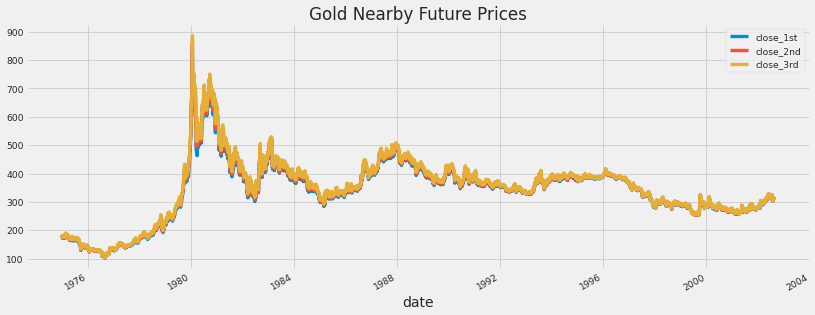

In [8]:
prices_nearby.plot()
plt.title('Gold Nearby Future Prices')
plt.show()

In [10]:
price_vol = prices_nearby.pct_change().dropna().rolling(252).std().dropna()*np.sqrt(252)

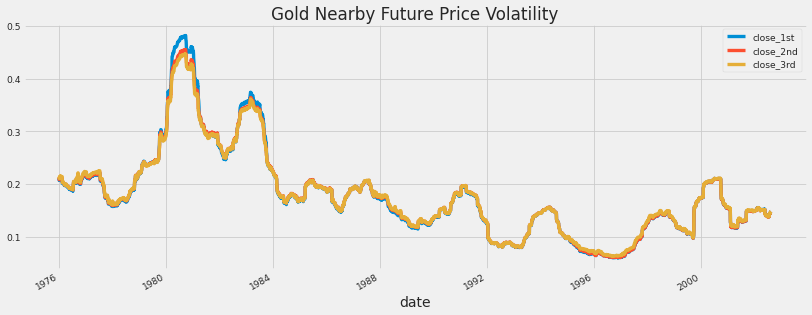

In [11]:
price_vol.plot()
plt.title('Gold Nearby Future Price Volatility')
plt.show()

## Generating Constant Maturity Price Curve

Defining the list to constant maturity period we wish to calculate a price as follows:  

| Period        | Number of Days |   | Period        | Number of Days |
|:-------------:|:-------------:|---|:-------------:|:-------------:|
| 1 day | 1 |   | 3 months | 90 |
| 1 week | 5 |   | 6 months | 180 |
| 1 month | 30 |   | 1 year | 360 |
| 2 months | 60 |   | 2 years | 720 |

Interpolation is performed with a cubic spline.

In [12]:
prices_full = pd.DataFrame(prices_full.groupby(['date','days_to_maturity'])['close'].mean())
prices_full.sort_index(level=['date', 'days_to_maturity'], inplace=True)

In [13]:
from scipy import interpolate

idx = pd.IndexSlice

cm_points = [1,5,30,60,90,180,360,720]
cm = pd.DataFrame(cm_points, columns=['days_to_maturity'])
cm['close'] = np.nan

const_mat = []

for dt in tqdm(prices_full.index.levels[0]):
    sample = prices_full.loc[idx[dt,:],:]
    sample.reset_index(inplace=True)
    
    if sample.shape[0] > 1:
#         f = interpolate.interp1d(sample.days_to_maturity, sample.close, fill_value="extrapolate")
        f = interpolate.CubicSpline(sample.days_to_maturity, sample.close, extrapolate=True)

        new_sample = pd.concat([sample[['days_to_maturity','close']], \
                                cm[~cm.days_to_maturity.isin(sample.days_to_maturity)]]) \
                                .sort_values('days_to_maturity') \
                                .reset_index(drop=True)

        new_sample.close = f(new_sample.days_to_maturity)
        new_sample = new_sample[new_sample.days_to_maturity.isin(cm_points)]
        new_sample['date'] = dt
        new_sample['num_of_contracts'] = sample.shape[0]
        const_mat.append(new_sample)
    elif sample.shape[0] == 1:
        print('Warning! Only one record in sample: {}'.format(dt))
        
        new_sample = cm.copy()
        new_sample['close'] = sample.iloc[0].close
        new_sample['date'] = dt
        new_sample['num_of_contracts'] = sample.shape[0]
        const_mat.append(new_sample)
    else:
        pass

const_mat = pd.concat(const_mat)

Warning! Only one record in sample: 2002-09-27 00:00:00
Warning! Only one record in sample: 2002-09-30 00:00:00
Warning! Only one record in sample: 2002-10-01 00:00:00



In [14]:
days_to_maturity_todrop = const_mat[const_mat.close < 0].days_to_maturity.unique().tolist()
const_mat = const_mat[~const_mat.days_to_maturity.isin(days_to_maturity_todrop)]

const_mat.drop('num_of_contracts', axis=1, inplace=True)

const_mat.set_index(['date', 'days_to_maturity'], inplace=True)
const_mat = const_mat.unstack('days_to_maturity')

## Generating Constant Maturity Volatility Curve

All in a single line of code:
1. Calculating the daily returns of each period
2. Calculating the rolling volatilily
3. Annualising the volatility

In [15]:
const_mat_vol = const_mat.pct_change().dropna().rolling(252).std().dropna()*np.sqrt(252)

## 3D Plots

Given that the raw data between 1996 and 2000 are more complete, we choose to plot the surfaces between 1996 and 2000.

In [19]:
import plotly.graph_objects as go

plotdata = const_mat['1996':'2000'].resample('M').fillna('ffill')

x = plotdata.columns.levels[1]
y = plotdata.index.strftime('%b-%y').tolist()
z = plotdata.values

fig = go.Figure(data=[go.Surface(x=x,y=y,z=z)])

fig.update_layout(title='Gold Futures Price Curve', autosize=True, 
                  width=800, height=600, 
                  scene=dict(
                      xaxis = dict(
                          title = 'Days to Maturity',
                      ),
                      yaxis = dict(
                          title = 'Date',
                      ),
                      zaxis = dict(
                          title = 'Price',
                      ),
                      aspectmode='manual',
                      aspectratio=dict(x=2,y=4,z=1),
                   ),
                  margin=dict(l=65, r=50, b=65, t=90))

fig.show()

**Observations**:
1. Gold future prices are mostly in contango
2. Gold future prices in a decreasing trend between 1996 to 2000

In [18]:
plotdata = const_mat_vol['1996':'2000'].resample('M').fillna('ffill')

x = plotdata.columns.levels[1]
y = plotdata.index.strftime('%b-%y').tolist()
z = plotdata.values

fig = go.Figure(data=[go.Surface(x=x,y=y,z=z)])

fig.update_layout(title='Gold Futures Price Volatiliy Curve', autosize=True, 
                  width=800, height=600, 
                  scene=dict(
                      xaxis = dict(
                          title = 'Days to Maturity',
                      ),
                      yaxis = dict(
                          title = 'Date',
                      ),
                      zaxis = dict(
                          title = 'Volatility',
                      ),
                      aspectmode='manual',
                      aspectratio=dict(x=2,y=4,z=1),
                   ),
                  margin=dict(l=65, r=50, b=65, t=90))

fig.show()

**Observations**:
1. Volatility tends to be constant across all maturity periods
2. Volatility trending up between 1996 to 2000